In [1]:
#Figure 3 - October 2023
#Preprocessing of Chl-a inputs into monthly median
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import glob
import dask

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm

import cmocean
import colorcet as cc
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = './cartopy_shapefiles'

In [2]:
#VIIRS for median
ds_input = xr.open_mfdataset('/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/INPUT/Input_obs9_*.nc')
ds_input = ds_input.transpose('time', 'latitude', 'longitude')
a = ds_input.mask.where(ds_input.mask==6)
mask = np.isnan(a)
mask = ~mask   
ds_input = ds_input.assign(variables={"mask": (('latitude','longitude'), mask.data)}) 

ds_out = xr.open_mfdataset('/home2/datawork/epauthen/Globcolour_coarse/VIR*.nc')
ds_out = ds_out.rename({'CHL1_coarse':'chloro'})
ds_out = ds_out.sel(latitude = slice(-50,50))
ds_out = ds_out.assign(variables={"mask": (('latitude','longitude'), ds_input.mask.data)}) 
y_test = ds_out.where(ds_out.mask == 1).load()
#
# Compute weighted median by timestep
weights = np.cos(np.deg2rad(y_test.latitude))
weights.name = "weights"
y_testw = y_test.chloro.weighted(weights)
chloro_qua = y_testw.quantile(dim = ("longitude", "latitude"),q=0.5)
VIR = y_test.assign(variables={"chloro_qua": (('time'), chloro_qua.data)}) 
VIR

<xarray.Dataset>
Dimensions:     (time: 132, latitude: 401, longitude: 1440)
Coordinates:
  * time        (time) datetime64[ns] 2012-01-01 2012-02-01 ... 2022-12-01
  * longitude   (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude    (latitude) float32 -50.0 -49.75 -49.5 -49.25 ... 49.5 49.75 50.0
Data variables:
    chloro      (time, latitude, longitude) float32 nan 0.1769 ... nan nan
    mask        (latitude, longitude) float64 nan 1.0 1.0 1.0 ... 1.0 1.0 1.0
    chloro_qua  (time) float64 0.1335 0.1254 0.1243 ... 0.1456 0.1368 0.14
Attributes: (12/53)
    Conventions:                CF-1.4
    title:                      GlobColour monthly VIIRSN product
    product_name:               L3m_20120101-20120131__GLOB_4_GSM-VIR_CHL1_MO...
    product_type:               month
    product_version:            2020.0
    product_level:              3
    ...                         ...
    references:                 http://www.globcolour.info
    contact:                    service@globcolour.info
    copyright:                  Copyright ACRI-ST - GlobColour. GlobColour ha...
    history:                    20201103T174252Z: globcolour_l3_reproject.sh ...
    input_files:                V2012002210600.L2_SNPP_OC.nc,V2012002211200.L...
    input_files_reprocessings:  2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,201...

In [3]:
#CCI
ds_out = xr.open_mfdataset('/home2/datawork/epauthen/Ocean-Colour-CCI/OC_CCI_Coarse/OC_CCI_chloro_a_*.nc')
ds_out = ds_out.rename({'chlor_a_coarse':'chloro'})
ds_out = ds_out.sel(latitude = slice(-50,50))
ds_out = ds_out.assign(variables={"mask": (('latitude','longitude'), ds_input.mask.data)}) 
y_test = ds_out.where(ds_out.mask == 1).load()
#
# Compute weighted median by timestep
weights = np.cos(np.deg2rad(y_test.latitude))
weights.name = "weights"
y_testw = y_test.chloro.weighted(weights)
chloro_qua = y_testw.quantile(dim = ("longitude", "latitude"),q=0.5)
CCI = y_test.assign(variables={"chloro_qua": (('time'), chloro_qua.data)}) 

In [4]:
#GSM
data_input = '/home2/datawork/epauthen/Globcolour_coarse/'
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    MODVIR    = xr.open_mfdataset(data_input + "MODVIR_*.nc")
    MERMOD    = xr.open_mfdataset(data_input + "MERMOD_*.nc")
    MERMODVIR = xr.open_mfdataset(data_input + "MERMODVIR_*.nc")
    MERMODSWF = xr.open_mfdataset(data_input + "MERMODSWF_*.nc")
    SWF    = xr.open_mfdataset(data_input + "SWF_*.nc")
    SWF    = SWF.sel(time = slice('1997-09','2002-06'))
    ds_gsm = MODVIR.merge(MERMOD)
    ds_gsm = ds_gsm.merge(MERMODSWF)
    ds_gsm = ds_gsm.merge(SWF)
    ds_out = ds_gsm.merge(MERMODVIR)
    ds_out = ds_out.rename({'CHL1_coarse': 'chloro'})
    ds_out = ds_out.sel(latitude = slice(-50,50))
    ds_out = ds_out.assign(variables={"mask": (('latitude','longitude'), ds_input.mask.data)}) 
    y_test = ds_out.where(ds_out.mask == 1).load()
#
# Compute weighted median by timestep
weights = np.cos(np.deg2rad(y_test.latitude))
weights.name = "weights"
y_testw = y_test.chloro.weighted(weights)
chloro_qua = y_testw.quantile(dim = ("longitude", "latitude"),q=0.5)
GSM = y_test.assign(variables={"chloro_qua": (('time'), chloro_qua.data)}) 


In [5]:
#Globcolour CMEMS for median
data_output = "/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/Globcolour_cmems_coarse/"
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out = xr.open_mfdataset(data_output + "Globcolour_CMEMS_chl_*.nc")
ds_out = ds_out.rename({'chl':'chloro'})
ds_out = ds_out.sel(latitude = slice(-50,50))
ds_out = ds_out.assign(variables={"mask": (('latitude','longitude'), ds_input.mask.data)}) 
y_test = ds_out.where(ds_out.mask == 1)

# Compute weighted median by timestep
weights = np.cos(np.deg2rad(y_test.latitude))
weights.name = "weights"
y_testw = y_test.chloro.weighted(weights)
chloro_qua = y_testw.quantile(dim = ("longitude", "latitude"),q=0.5)
GCMEMS = y_test.assign(variables={"chloro_qua": (('time'), chloro_qua.data)}) 


/home2/datahome/epauthen/conda-env/EP_kernel/lib/python3.8/site-packages/dask/array/gufunc.py:429: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(  # First try to compute meta
/home2/datahome/epauthen/conda-env/EP_kernel/lib/python3.8/site-packages/dask/array/gufunc.py:446: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(


In [6]:
#YU
data_output = "/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/Chloro_Yu_2023_coarse/"
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out = xr.open_mfdataset(data_output + "Yu_chloro_*.nc")
ds_out = ds_out.rename({'chl':'chloro'})
ds_out = ds_out.sel(latitude = slice(-50,50))
ds_out = ds_out.assign(variables={"mask": (('latitude','longitude'), ds_input.mask.data)}) 
y_test = ds_out.where(ds_out.mask == 1)

# Compute weighted median by timestep
weights = np.cos(np.deg2rad(y_test.latitude))
weights.name = "weights"
y_testw = y_test.chloro.weighted(weights)
chloro_qua = y_testw.quantile(dim = ("longitude", "latitude"),q=0.5)
YU = y_test.assign(variables={"chloro_qua": (('time'), chloro_qua.data)}) 

/home2/datahome/epauthen/conda-env/EP_kernel/lib/python3.8/site-packages/dask/array/gufunc.py:429: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(  # First try to compute meta
/home2/datahome/epauthen/conda-env/EP_kernel/lib/python3.8/site-packages/dask/array/gufunc.py:446: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(


In [7]:
#Multiobs
data_output = '/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/MULTIOBS_GLO_BIO_BGC_3D_REP_015_010/Surface/'
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out = xr.open_mfdataset(data_output + "CMEMS_chl_*.nc")
ds_out = ds_out.resample(time="1M").mean()
ds_out = ds_out.rename({'chl':'chloro'})
ds_out = ds_out.sel(latitude = slice(-50,50))
ds_bathy = xr.open_dataset('/home2/datawork/epauthen/ETOPO1_Ice_g_gmt4.grd', engine='netcdf4')
res = ds_bathy.z.interp(x=ds_out.longitude, y=ds_out.latitude,method = 'linear')
ds_out = ds_out.assign(variables={"bathymetry": (('latitude','longitude'), res.data)})
ds_out = ds_out.where(ds_out.bathymetry < -200)
y_test = ds_out.drop(['bathymetry'])

# Compute weighted median by timestep
weights = np.cos(np.deg2rad(y_test.latitude))
weights.name = "weights"
y_testw = y_test.chloro.weighted(weights)
chloro_qua = y_testw.quantile(dim = ("longitude", "latitude"),q=0.5)
MCMEMS = y_test.assign(variables={"chloro_qua": (('time'), chloro_qua.data)}) 

/home2/datahome/epauthen/conda-env/EP_kernel/lib/python3.8/site-packages/dask/array/gufunc.py:429: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(  # First try to compute meta
/home2/datahome/epauthen/conda-env/EP_kernel/lib/python3.8/site-packages/dask/array/gufunc.py:446: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(


In [8]:
#AVW
data_input = '/home2/datawork/epauthen/Globcolour_AVW_coarse/'
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    MODVIR    = xr.open_mfdataset(data_input + "MODVIR_*.nc")
    MERMOD    = xr.open_mfdataset(data_input + "MERMOD_*.nc")
    MERMODVIR = xr.open_mfdataset(data_input + "MERMODVIR_*.nc")
    MERMODSWF = xr.open_mfdataset(data_input + "MERMODSWF_*.nc")
    SWF    = xr.open_mfdataset(data_input + "SWF_*.nc")
    SWF    = SWF.sel(time = slice('1997-09','2002-06'))
    ds_gsm = MODVIR.merge(MERMOD)
    ds_gsm = ds_gsm.merge(MERMODSWF)
    ds_gsm = ds_gsm.merge(SWF)
    ds_out = ds_gsm.merge(MERMODVIR)
    ds_out = ds_out.rename({'CHL1_coarse': 'chloro'})
    ds_out = ds_out.sel(latitude = slice(-50,50))
    ds_out = ds_out.assign(variables={"mask": (('latitude','longitude'), ds_input.mask.data)}) 
    y_test = ds_out.where(ds_out.mask == 1).load()

# Compute weighted median by timestep
weights = np.cos(np.deg2rad(y_test.latitude))
weights.name = "weights"
y_testw = y_test.chloro.weighted(weights)
chloro_qua = y_testw.quantile(dim = ("longitude", "latitude"),q=0.5)
AVW = y_test.assign(variables={"chloro_qua": (('time'), chloro_qua.data)}) 


In [17]:
path_out = '/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/Preproc_GRL/'
#VIR.chloro_qua.to_netcdf(path_out + 'VIIRS_median.nc')
#GCMEMS.chloro_qua.to_netcdf(path_out + 'GCMEMS_median.nc')
#GSM.chloro_qua.to_netcdf(path_out + 'GSM_median.nc')
#CCI.chloro_qua.to_netcdf(path_out + 'CCI_median.nc')
#YU.chloro_qua.to_netcdf(path_out + 'YU_median.nc')
#MCMEMS.chloro_qua.to_netcdf(path_out + 'MCMEMS_median.nc')
AVW.chloro_qua.to_netcdf(path_out + 'AVW_median.nc')


In [ ]:
#GCMEMS = xr.open_dataset(path_out + 'GCMEMS_median.nc')
#MCMEMS = xr.open_dataset(path_out + 'MCMEMS_median.nc')
#VIR = xr.open_dataset(path_out + 'VIIRS_median.nc')
#GSM = xr.open_dataset(path_out + 'GSM_median.nc')
#AVW = xr.open_dataset(path_out + 'AVW_median.nc')
#CCI = xr.open_dataset(path_out + 'CCI_median.nc')
#YU = xr.open_dataset(path_out + 'YU_median.nc')


/home2/datahome/epauthen/conda-env/EP_kernel/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


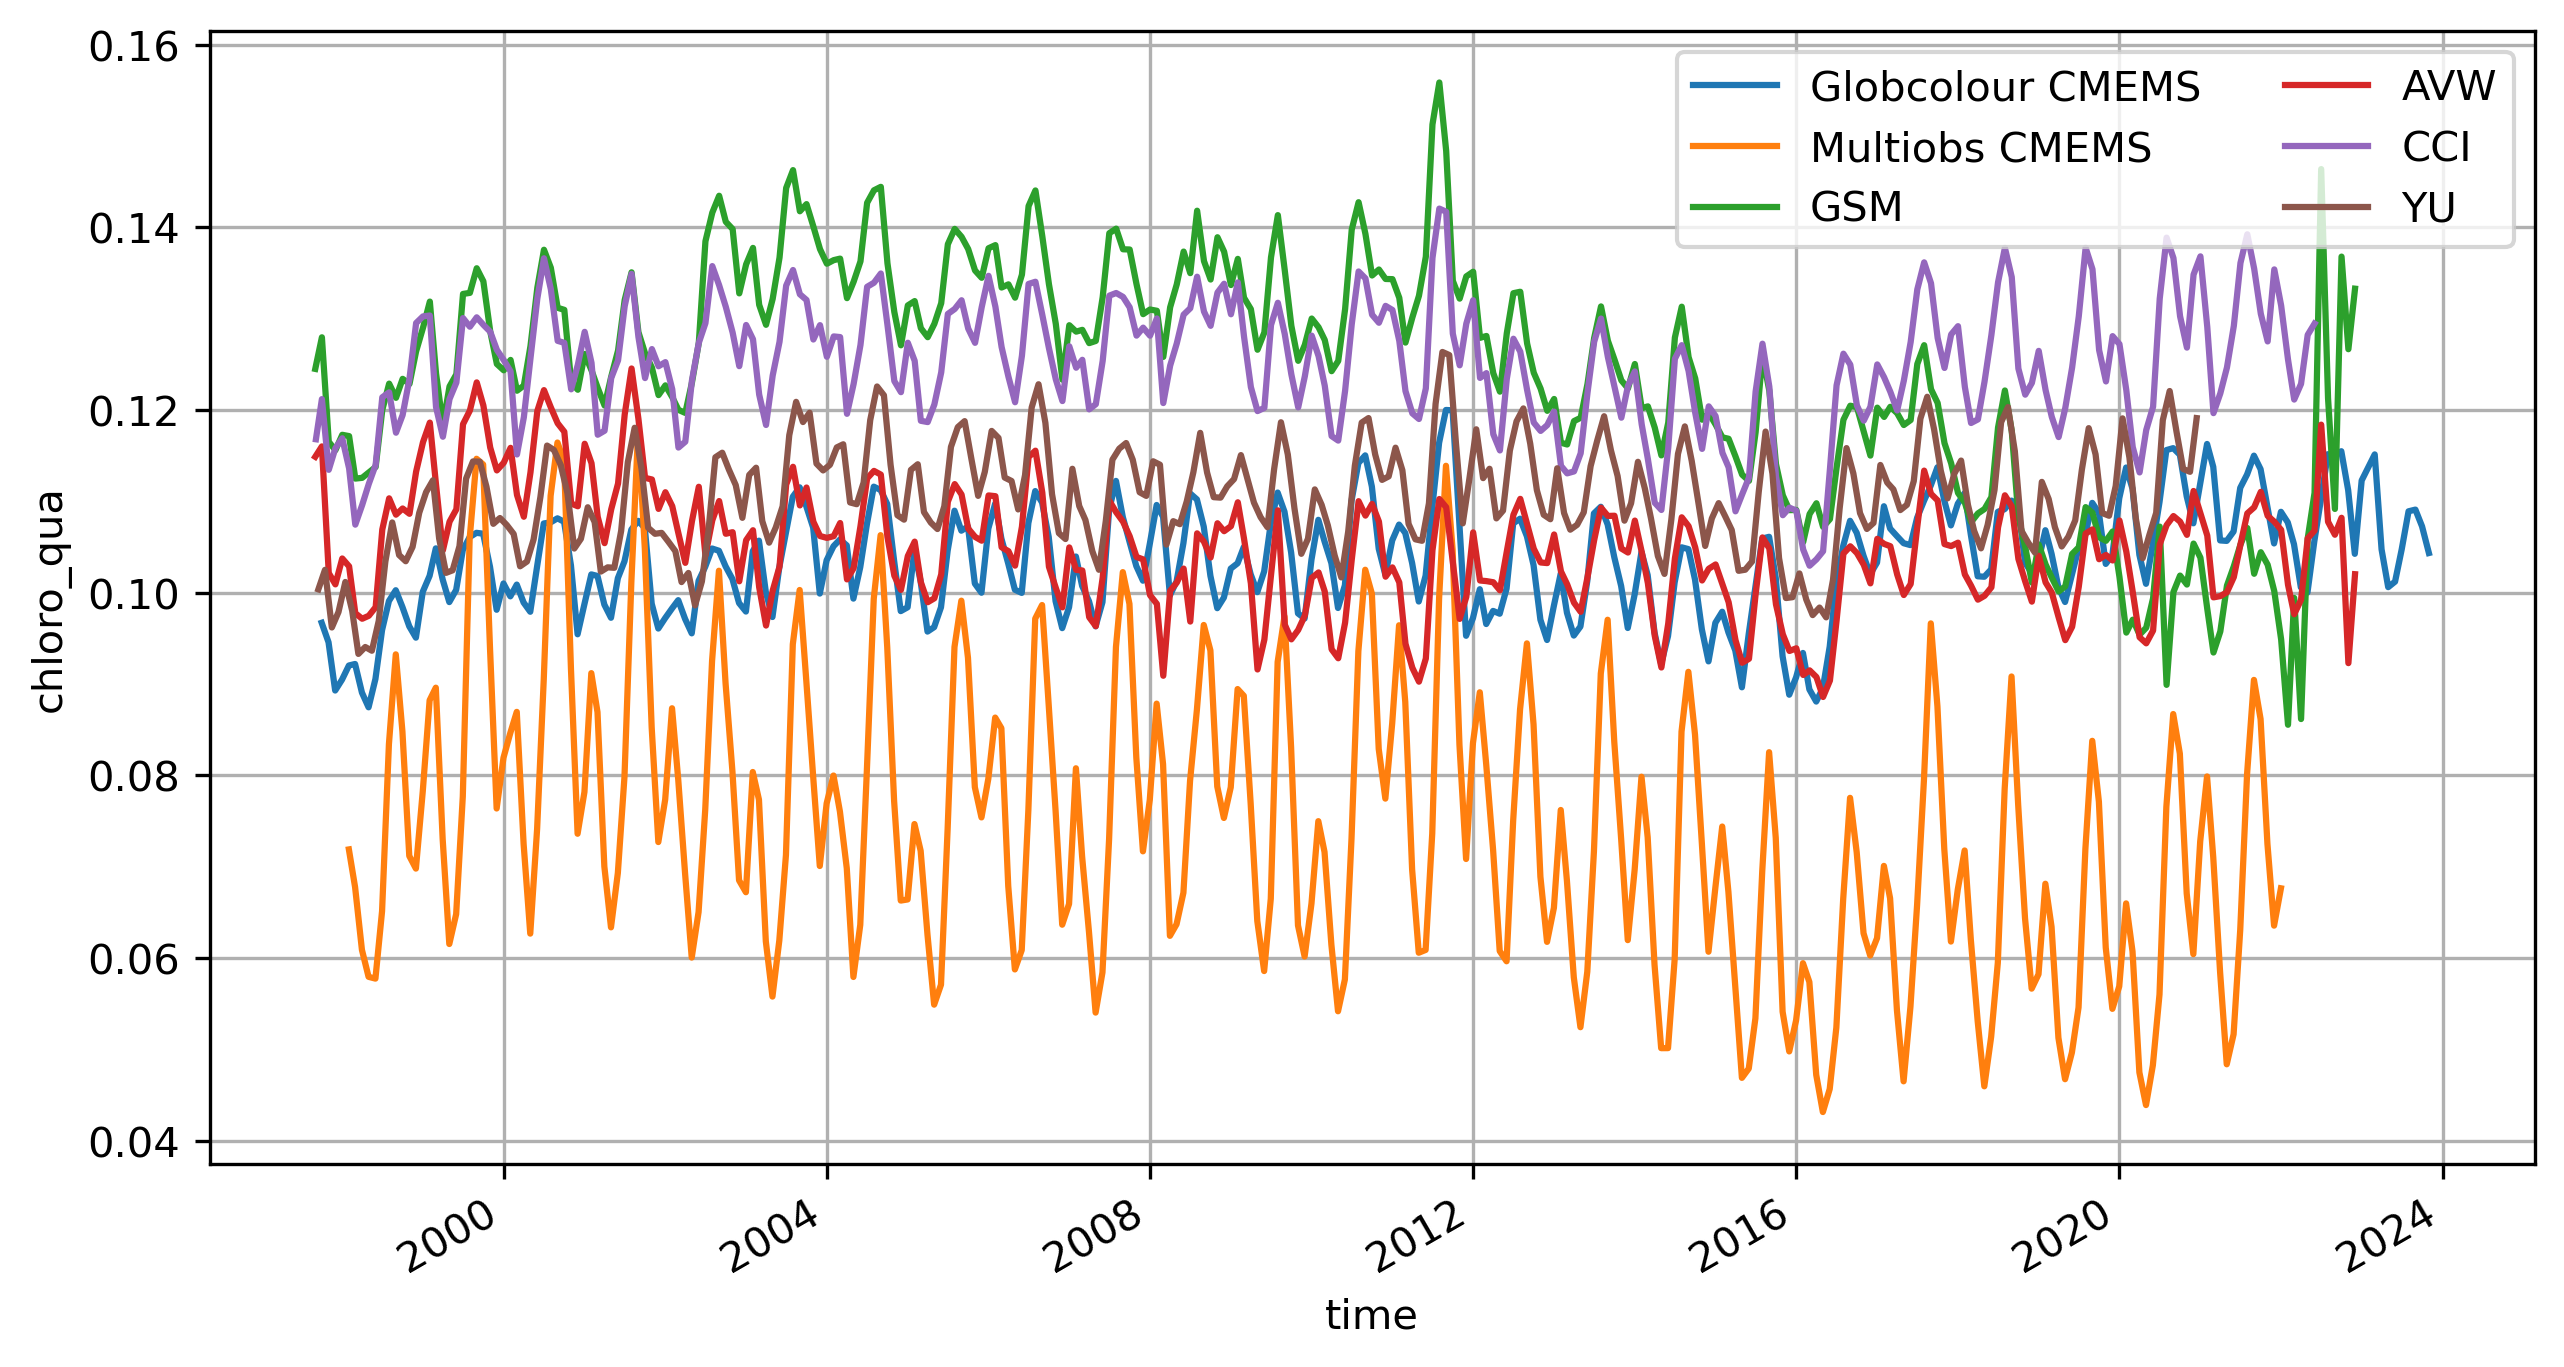

In [11]:
fig = plt.subplots(1,1, figsize=(10,5), dpi=300)
GCMEMS.chloro_qua.plot(label = "Globcolour CMEMS")
MCMEMS.chloro_qua.plot(label = "Multiobs CMEMS")
#VIR.chloro_qua.plot(label = "VIIRS")
GSM.chloro_qua.plot(label = "GSM")
AVW.chloro_qua.plot(label = "AVW")
CCI.chloro_qua.plot(label = "CCI")
YU.chloro_qua.plot(label = "YU")
plt.legend(ncol = 2)
plt.grid()

In [ ]:
ds_input.mask.plot()

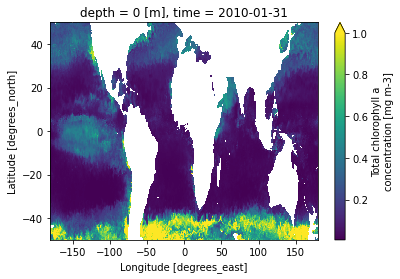

In [15]:
MCMEMS.chloro.sel(time = "2010-01").plot(vmax = 1)

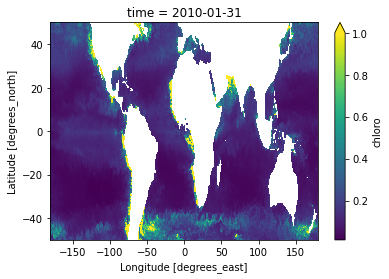

In [14]:
GCMEMS.chloro.sel(time = "2010-01").plot(vmax = 1)

In [16]:
MCMEMS

<xarray.Dataset>
Dimensions:     (time: 288, latitude: 400, longitude: 1440)
Coordinates:
    depth       int16 0
  * latitude    (latitude) float32 -49.88 -49.62 -49.38 ... 49.38 49.62 49.88
  * longitude   (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time        (time) datetime64[ns] 1998-01-31 1998-02-28 ... 2021-12-31
Data variables:
    chloro      (time, latitude, longitude) float32 dask.array<chunksize=(1, 400, 1440), meta=np.ndarray>
    chloro_qua  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>